# "Smart maintenance based on vehicle CAN bus data from scratch in Python"
> "In this article we prototype an algorithm that automatically scores engine health based on vehicle CAN bus data."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, numpy, data-driven products, smart maintenance, scikit-learn]

# Summary

Equipment that behaves anomalously or breaks down unexpectedly is a major cost driver in **manufacturing**, **logistics**, **public transport**, and any other sector that relies on complex machinery.

A big promise of data analytics and machine learning in this space is to detect anomalies in machinery automatically and to alert their user of occurring faults.
As an extension, the prediction of machinery faults and breakdowns is an important field of application.

Automated detection and prediction of machinery breakdown is a key algorithmic approach behind **smart and predictive maintenance**.

In this article we showcase a simple algorithmic approach for anomaly detection in the space of automated engine health detection.

Our approach here can be an interesting starting point for the development of **smart telematics solutions** for automated and predictive vehicle breakdown detection.

# Fetch the data

We'll make use of an open data set of vehicle CAN bus data, called
[Automotive CAN bus data: An Example Dataset from the AEGIS Big Data Project](https://zenodo.org/record/3267184#.XmCx8hNKh24).

A CAN bus is a local network of sensors and actuators in modern vehicles that provides a stream of data for all important signals of a vehicle - such as its present velocity, interior temperature, and potentially hundreds of other signals.

This data set encompasses time series data (traces) of various vehicles driven by different drivers.

Let's go ahead and download a data set for driver 1 and a data set for driver 2:

In [0]:
!wget --quiet https://zenodo.org/record/3267184/files/20181113_Driver1_Trip1.hdf

In [0]:
!wget --quiet https://zenodo.org/record/3267184/files/20181114_Driver2_Trip3.hdf

# Load libraries

Here we import all necessary Python libraries for our analysis and algorithm:

In [0]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.mixture import GaussianMixture

In [0]:
plt.rcParams['figure.figsize'] = (10,10)
sns.set(style="darkgrid")

# Load vehicle data

Let's load the data for driver 1 and driver 2 into memory:

In [0]:
driver_1 = h5py.File('20181113_Driver1_Trip1.hdf', 'r')
driver_2 = h5py.File('20181114_Driver2_Trip3.hdf', 'r')

Both files contain multiple subgroups of data, one of which is the aformentioned CAN bus:

In [6]:
list(driver_1.keys())

['AI', 'CAN', 'GPS', 'Math', 'Plugins']

In [7]:
list(driver_2.keys())

['AI', 'CAN', 'GPS', 'Math', 'Plugins']

# Turn time series data into tables

The CAN bus data comes in serialized form - written out in series in a nested format.

To handle the CAN bus data more efficiently we'll turn it into tables that are easier to inspect and handle.

In [0]:
data_driver_1 = {}
data_driver_2 = {}

for channel_name, channel_data in driver_1['CAN'].items():
  data_driver_1[channel_name] = channel_data[:, 0]

table_driver_1 = pd.DataFrame(
    data=data_driver_1,
    index=channel_data[:, 1]
)
table_driver_1 = table_driver_1.loc[:, table_driver_1.nunique() > 1]

for channel_name, channel_data in driver_2['CAN'].items():
  data_driver_2[channel_name] = channel_data[:, 0]

table_driver_2 = pd.DataFrame(
    data=data_driver_2,
    index=channel_data[:, 1]
)
table_driver_2 = table_driver_2.loc[:, table_driver_2.nunique() > 1]

The tabular data for driver 1 looks as follows - it holds 158,659 measured time points in 28 channels that we deem relevant:

In [9]:
table_driver_1

,AccPedal,AirIntakeTemperature,AmbientTemperature,BoostPressure,BrkVoltage,ENG_Trq_DMD,ENG_Trq_ZWR,ENG_Trq_m_ex,EngineSpeed_CAN,EngineTemperature,Engine_02_BZ,Engine_02_CHK,OilTemperature1,SCS_01_BZ,SCS_01_CHK,SCS_Cancel,SCS_Tip_Down,SCS_Tip_Set,SCS_Tip_Up,SteerAngle1,Trq_FrictionLoss,Trq_Indicated,VehicleSpeed,WheelSpeed_FL,WheelSpeed_FR,WheelSpeed_RL,WheelSpeed_RR,Yawrate1
0.000000,0.0,31.5,8.0,0.97,1.0,18.0,20.0,27.000000,809.500000,93.0,6.000000,168.000000,82.0,9.000000,27.000000,0.0,0.0,0.0,0.0,125.599998,29.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.190000
0.050000,0.0,31.5,8.0,0.97,1.0,18.0,20.0,27.000000,809.500000,93.0,6.000000,168.000000,82.0,9.000000,27.000000,0.0,0.0,0.0,0.0,125.599998,29.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.190000
0.100000,0.0,31.5,8.0,0.97,1.0,18.0,20.0,27.000000,810.215759,93.0,10.331579,163.663162,82.0,9.333000,26.000999,0.0,0.0,0.0,0.0,125.599998,29.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.209900
0.150000,0.0,31.5,8.0,0.97,1.0,18.0,20.0,27.384237,807.657654,93.0,9.605911,165.674881,82.0,9.833000,24.500999,0.0,0.0,0.0,0.0,125.599998,29.0,27.384237,0.0,0.0,0.0,0.0,0.0,0.204887
0.200000,0.0,31.5,8.0,0.97,1.0,18.0,20.0,27.000000,805.500000,93.0,4.358586,172.641418,82.0,10.333000,24.333000,0.0,0.0,0.0,0.0,125.599998,28.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7932.700195,0.0,25.5,9.5,0.98,0.0,20.0,19.0,29.000000,797.500000,96.0,8.174129,84.825874,96.0,10.493239,24.493240,0.0,0.0,0.0,0.0,14.100000,29.0,29.000000,0.0,0.0,0.0,0.0,0.0,0.130000
7932.750000,0.0,25.5,9.5,0.98,0.0,19.0,19.0,29.000000,800.500000,96.0,13.164251,145.835754,96.0,10.993991,24.993992,0.0,0.0,0.0,0.0,14.100000,29.0,29.000000,0.0,0.0,0.0,0.0,0.0,0.123609
7932.799805,0.0,25.5,9.5,0.98,0.0,19.0,19.0,29.000000,797.790588,96.0,2.177665,156.822342,96.0,11.494000,27.469999,0.0,0.0,0.0,0.0,14.100000,28.0,29.000000,0.0,0.0,0.0,0.0,0.0,0.178596
7932.850098,0.0,25.5,9.5,0.98,0.0,19.0,19.0,29.000000,796.000000,96.0,7.180095,153.739334,96.0,11.994000,29.969999,0.0,0.0,0.0,0.0,14.100000,28.0,29.000000,0.0,0.0,0.0,0.0,0.0,0.157268


The tabular data for driver 2 looks as follows - it holds 136,154 measured time points in 29 channels that we deem relevant:

In [10]:
table_driver_2

,AccPedal,AirIntakeTemperature,AmbientTemperature,BoostPressure,BrkVoltage,ENG_Trq_DMD,ENG_Trq_ZWR,ENG_Trq_m_ex,EngineSpeed_CAN,EngineTemperature,Engine_02_BZ,Engine_02_CHK,OilTemperature1,SCS_01_BZ,SCS_01_CHK,SCS_Cancel,SCS_Tip_Down,SCS_Tip_Restart,SCS_Tip_Set,SCS_Tip_Up,SteerAngle1,Trq_FrictionLoss,Trq_Indicated,VehicleSpeed,WheelSpeed_FL,WheelSpeed_FR,WheelSpeed_RL,WheelSpeed_RR,Yawrate1
0.000000,0.0,44.25,14.5,1.00,1.0,20.000000,21.0,30.000000,791.000000,96.0,6.000000,59.000000,94.0,10.000000,24.000000,0.0,0.0,0.0,0.0,0.0,4.800000,31.0,30.000000,0.0,0.0,0.0,0.0,0.0,0.140000
0.050000,0.0,44.25,14.5,1.00,1.0,21.000000,20.0,30.000000,791.000000,96.0,10.688680,102.688683,94.0,10.000000,24.000000,0.0,0.0,0.0,0.0,0.0,4.800000,31.0,30.000000,0.0,0.0,0.0,0.0,0.0,0.120000
0.100000,0.0,44.25,14.5,1.00,1.0,21.000000,20.0,30.000000,791.165039,96.0,4.381188,105.079208,94.0,10.110166,24.110165,0.0,0.0,0.0,0.0,0.0,4.800000,31.0,30.000000,0.0,0.0,0.0,0.0,0.0,0.148120
0.150000,0.0,44.25,14.5,1.00,1.0,21.000000,20.0,30.751268,787.500000,96.0,4.725888,104.725891,94.0,10.610916,24.610916,0.0,0.0,0.0,0.0,0.0,4.800000,31.0,30.751268,0.0,0.0,0.0,0.0,0.0,0.126384
0.200000,0.0,44.25,14.5,1.00,1.0,21.000000,20.0,31.000000,791.000000,96.0,9.733668,101.733665,94.0,11.111500,25.557501,0.0,0.0,0.0,0.0,0.0,4.800000,31.0,31.000000,0.0,0.0,0.0,0.0,0.0,0.135592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807.450195,0.0,25.50,10.5,0.98,1.0,21.000000,21.0,31.000000,815.500000,94.5,10.693069,118.693069,95.0,5.992500,22.394501,0.0,0.0,0.0,0.0,0.0,37.400002,30.0,31.000000,0.0,0.0,0.0,0.0,0.0,0.130326
6807.500000,0.0,25.50,10.5,0.98,1.0,21.000000,21.0,30.682692,813.500000,94.5,5.192307,120.884613,95.0,0.100500,18.100500,0.0,0.0,0.0,0.0,0.0,37.400002,30.0,30.682692,0.0,0.0,0.0,0.0,0.0,0.150000
6807.549805,0.0,25.50,10.5,0.98,1.0,21.000000,21.0,31.000000,816.000000,94.5,4.676768,120.676765,95.0,0.600500,18.600500,0.0,0.0,0.0,0.0,0.0,37.476120,30.0,31.000000,0.0,0.0,0.0,0.0,0.0,0.140351
6807.600098,0.0,25.50,10.5,0.98,1.0,20.323383,21.0,30.000000,819.587524,94.5,9.676617,74.726372,95.0,1.100550,18.698349,0.0,0.0,0.0,0.0,0.0,37.476616,30.0,30.000000,0.0,0.0,0.0,0.0,0.0,0.140000


# Monitoring engine health

One use case of automated anomaly detection lies in checking the health status of a vehicle's engine.

Here we'll look at engine oil temperature as a function of velocity: As you'll notice in the below plots, oil temperature goes up with higher velocity and increased operating duration.

## Engine 1 - healthy
Let's look at the engine of the vehicle of driver 1 where engine oil temperature appears normal as it keeps to within a certain band:

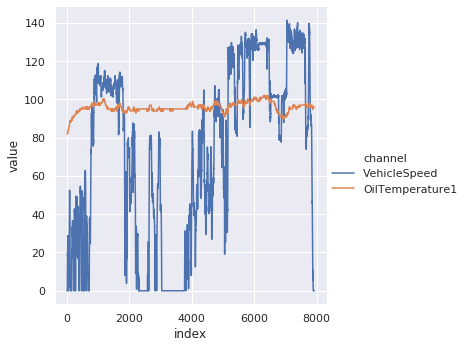

In [26]:
temperature_1 = table_driver_1[['VehicleSpeed', 'OilTemperature1']].copy()

sns.relplot(
    x='index',
    y='value',
    hue='channel',
    kind='line',
    data=temperature_1.reset_index().melt(id_vars='index', var_name='channel')
);

Plotting engine oil temperature against vehicle velocity makes the correlation between the two metrics more apparent:

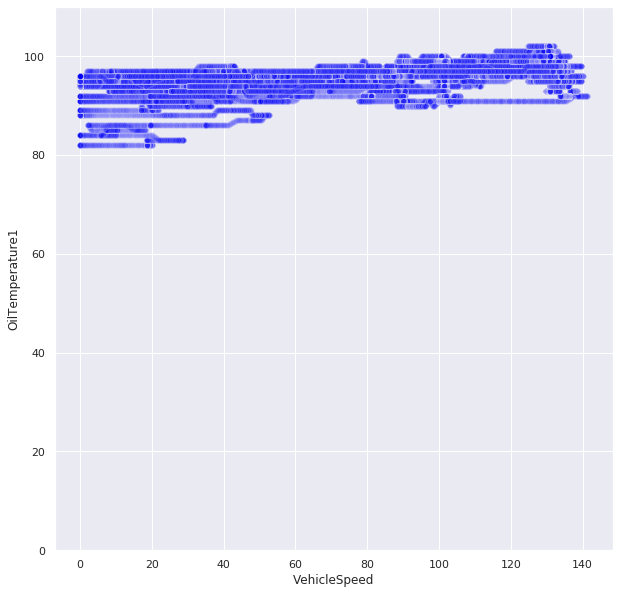

In [43]:
plot = sns.scatterplot(
    x='VehicleSpeed',
    y='OilTemperature1',
    data=temperature_1,
    color='blue',
    alpha=.1
);
plot.axes.set_ylim(0., 110.);

## Engine 2 - unhealthy

Let's look at velocity and engine oil temperature for vehicle 2 (where I deliberately introduce an anomaly between 5000 and 5500 seconds of the trace).

You'll notice a spike in engine oil temperature which indicates unhealthy behavior of the vehicle's engine:

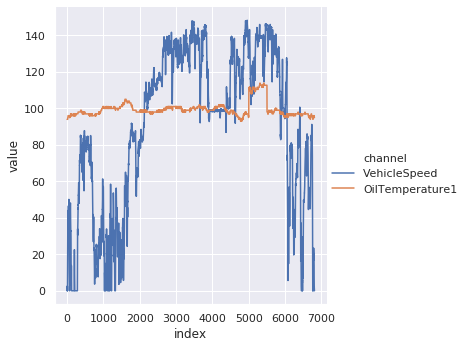

In [27]:
temperature_2 = table_driver_2[['VehicleSpeed', 'OilTemperature1']].copy()
temperature_2.loc[5000:5500, 'OilTemperature1'] *= 1.15

sns.relplot(
    x='index',
    y='value',
    hue='channel',
    kind='line',
    data=temperature_2.reset_index().melt(id_vars='index', var_name='channel')
);

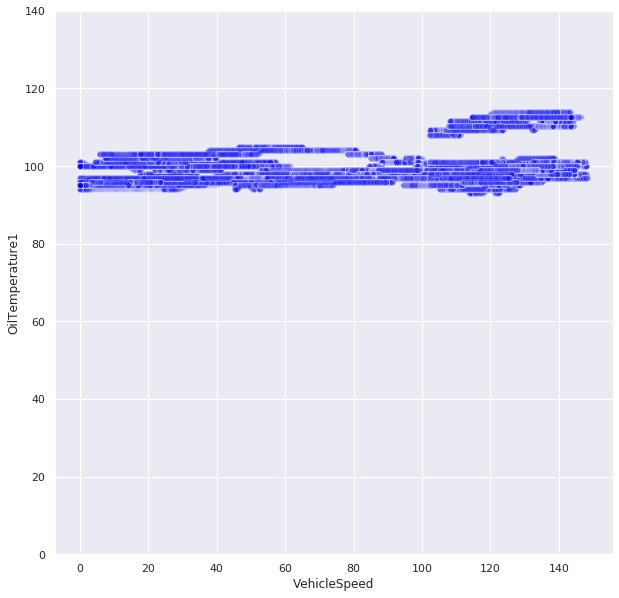

In [42]:
plot = sns.scatterplot(
    x='VehicleSpeed',
    y='OilTemperature1',
    data=temperature_2,
    color='blue',
    alpha=.1
);
plot.axes.set_ylim(0., 140.);

# Anomaly detection algorithm: learn what observations to expect to recognize anomalies

Let's look at the visual distribution of engine oil temperature and velocity again and directly compare vehicle 1 with vehicle 2.

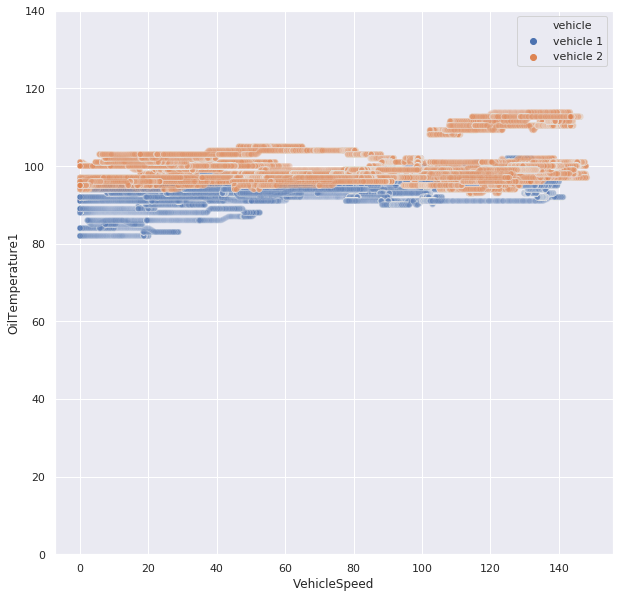

In [46]:
temperature_1['vehicle'] = 'vehicle 1'
temperature_2['vehicle'] = 'vehicle 2'
combined = pd.concat([temperature_1, temperature_2], axis=0, sort=True)

plot = sns.scatterplot(
    x='VehicleSpeed',
    y='OilTemperature1',
    data=combined,
    hue='vehicle',
    alpha=.1
);
plot.axes.set_ylim(0., 140.);

You'll notice that the engine oil temperature of vehicle 2 tends to be higher than of vehicle 1 and vehicle 2 shows an island of high engine oil temperature separated from the bulk of data points.

We can use this by modelling the distribution of value pairs velocity and oil temperature that we would usually expect to observe.

Let's model the expected distribution of data points with a model called [Gaussian mixture models](https://scikit-learn.org/stable/modules/mixture.html).
This model fits a set of [Gaussian distributions](https://en.wikipedia.org/wiki/Normal_distribution) to the distribution of value pairs we observed for vehicle 1 - thus defining what a healthy distribution of values looks like.

In [0]:
model = GaussianMixture(n_components=4)

In [17]:
model.fit(temperature_1[['VehicleSpeed', 'OilTemperature1']])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

After training our model on the observations for vehicle 1, let's score the likelihood of observing each observation we have on vehicle 2:

In [0]:
temperature_2['health_score'] = model.score_samples(temperature_2[['VehicleSpeed', 'OilTemperature1']])

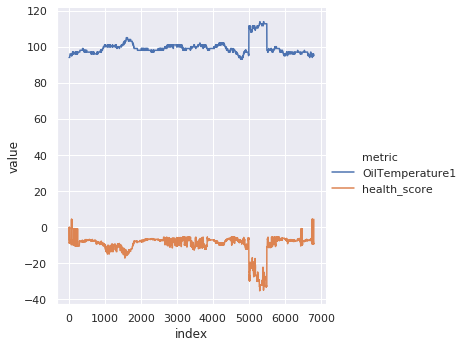

In [31]:
sns.relplot(
    x='index',
    y='value',
    hue='metric',
    kind='line',
    data=temperature_2[['OilTemperature1', 'health_score']].reset_index().melt(id_vars='index', var_name='metric')
);  

To clarify what we did here: We learned what a healthy distribution of vehicle velocity and engine oil temperature looks like based on data from vehicle 1 and applied this model to data from vehicle 2.

Looking at the health score we compute for vehicle 2 we notice that our health score drops markdely between 5000 and 5500 seconds into our CAN bus trace - exactly where oil temperature spikes unhealthily.

While we would need to do a lot more validation and model calibration before we could use this approach in a live environment, we can already see the potential of this approach.

With this approach we can start devising data-driven products and services for smart telematics and smart maintenance applications.